# 4.1 Further classification of wheel movement states
- ballistic (True or False)
- choice (none, L, R)
- inflections (none, 1, more)

In [1]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd

from one.api import ONE
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import brainbox.behavior.wheel as wh
from scipy.signal import savgol_filter

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import concatenate_sessions, fix_discontinuities
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from postprocessing_functions import remove_states_str, best__kappa, best_lag_kappa, state_identifiability
from plotting_functions import plot_x_y_dynamics, plot_avg_state, align_bin_design_matrix, states_per_trial_phase, plot_states_aligned_trial, plot_states_aligned, traces_over_few_sates
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from wheel_functions import wheel_trial_epoch
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from one_functions_generic import prepro
from design_functions import wheel_velocity
# one = ONE(base_url='https://alyx.internationalbrainlab.org')
one = ONE(mode='remote')

## Parameters

In [2]:
bin_size = 0.1
multiplier = 1/bin_size

## Get data

In [3]:
# Load preprocessed data
results_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//4_analyses/'
os.chdir(results_path)
states_trial_type = pickle.load(open("states_trial_type.pkl", "rb"))

# Get extended states with wheel data

In [4]:

response_threshold = 0.3 # radians
velocity_threshold = 100 # degrees/s
monotonic_threshold = -.002
eids = np.unique(states_trial_type['session'])

mouse_movements_df = pd.DataFrame(columns=['session', 'movement_id', 'time', 'norm_time', 'wheel_pos', 
                                            'wheel_vel', 'wheel_pos_resp', 'wheel_vel_resp',  'ballistic', 'response'])

for e, eid in enumerate(eids[0:10]):

    session_trials = one.load_object(eid, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]

    # Get time of last unbiased trial
    unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
    time_trial_90 = list(unbiased['stimOff_times'])[-1]

    wheel_data = one.load_object(eid, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel_data.timestamps, wheel_data.position)

    # Calculate wheel velocity
    wheel_vel = wheel_velocity(bin_size, wheel_times, pos, unbiased)
    wheel_trace = np.array(wheel_vel['avg_wheel_vel'])

    df = states_trial_type.loc[(states_trial_type['session']==eid)].sort_values(by='Bin')

    check_states = np.array(df['identifiable_states'])
    on = [s[0] == '1' for s in check_states]
    df['wheel_on'] = np.zeros(len(df))
    df['wheel_on'][on] = 1

    df['dif'] = np.zeros(len(df)) * np.nan
    df['dif'][1:] = np.diff(df['wheel_on'])

    movement_onsets = np.array(df.loc[df['dif']==1., 'Bin'])
    movement_offsets = np.array(df.loc[df['dif']==-1., 'Bin'])

    # Calculate per movement

    for m, onset in enumerate(movement_onsets[:-1]):
        try:
            movement_df = pd.DataFrame(columns=['session', 'movement_id', 'time', 'norm_time', 'wheel_pos', 
                                                'wheel_vel', 'wheel_pos_resp', 'wheel_vel_resp', 
                                                'ballistic', 'response'])
            
            offset = movement_offsets[m]
            movement_pos = wheel_vel.loc[(wheel_vel['Bin']>=onset)
                                        & (wheel_vel['Bin']<offset), 'Wheel position']
            movement_times = wheel_vel.loc[(wheel_vel['Bin']>=onset)
                                        & (wheel_vel['Bin']<offset), 'Wheel times']
            
            time_interval = (offset - onset) * .1 # convert from Bins to seconds
            movement_pos_deg = movement_pos * 180 / np.pi # convert from radians to degrees
            movement_velocity = np.diff(movement_pos_deg) /  np.diff(movement_times)
            norm_movement_pos = np.array(movement_pos) - np.array(movement_pos)[0]

            # Save data
            movement_df['time'] = movement_times
            movement_df['norm_time'] = movement_times - np.array(movement_times)[0]
            movement_df['wheel_pos'][1:] = norm_movement_pos[1:]
            movement_df['wheel_vel'][1:] = movement_velocity
            movement_df['movement_id'] = m
            movement_df['session'] = eid

            # Find positions above threshold
            pos_above_thr = np.where(np.abs(norm_movement_pos)>.3)
            if len(pos_above_thr[0]) > 0:
                response_index = np.where(np.abs(norm_movement_pos)>.3)[0][0]
                movement_df['response'] = np.sign(norm_movement_pos[response_index])

                # Find ballistic movements
                # Velocity above threshold
                vel_above_thr = np.where(np.abs(movement_velocity)>=100)
                # Response duration
                response_duration = np.array(movement_times)[response_index] - np.array(movement_times)[0]
                # Monotonic change?
                response_movement = norm_movement_pos[:response_index]
                smoothed_movement = savgol_filter(response_movement, 100, 2)
                significant_inflection = np.where(np.diff(np.abs(smoothed_movement))<monotonic_threshold)

                movement_df['wheel_pos_resp'][:response_index] = norm_movement_pos[:response_index]
                movement_df['wheel_vel_resp'][:response_index] = movement_velocity[:response_index]

                if len(vel_above_thr[0]) > 0:
                    # Check if threshold achieved before 1 s and 
                    # velocity threshold achieved before response threshold and
                    # monotonically changing before response threshold
                    if (np.sum(vel_above_thr[0] < response_index) > 0) & (response_duration < 1) & (len(significant_inflection[0]) == 0):
                        movement_df['ballistic'] = True
                    else:
                        movement_df['ballistic'] = False
                else:
                    movement_df['ballistic'] = False
            else:
                movement_df['response'] = np.nan
                movement_df['ballistic'] = False
                
            # Save to big df
            if len(mouse_movements_df) == 0:
                mouse_movements_df = movement_df.copy()
            else:
                mouse_movements_df = mouse_movements_df.append(movement_df)
        except:
            print('Movement not available?')

KeyboardInterrupt: 

# Get extended states without wheel data

In [16]:

response_threshold = 0.3 # radians
velocity_threshold = 100 # degrees/s
monotonic_threshold = -.002
eids = np.unique(states_trial_type['session'])

mouse_movements_df = pd.DataFrame()

for e, eid in enumerate(eids):

    # Get trials
    session_trials = one.load_object(eid, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
    time_trial_90 = list(unbiased['stimOff_times'])[-1]

    # Get whel data
    wheel_data = one.load_object(eid, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel_data.timestamps, wheel_data.position)
    wheel_vel = wheel_velocity(bin_size, wheel_times, pos, unbiased)
    wheel_trace = np.array(wheel_vel['avg_wheel_vel'])

    # Find movements
    df = states_trial_type[['Bin', 'trial_id', 'mouse_name', 'session', 'identifiable_states']].copy()
    df = df.loc[(df['session']==eid)].sort_values(by='Bin')
    check_states = np.array(df['identifiable_states'])
    on = [s[0] == '1' for s in check_states]
    df['wheel_on'] = np.zeros(len(df))
    df['wheel_on'][on] = 1
    df['dif'] = np.zeros(len(df)) * np.nan
    df['dif'][1:] = np.diff(df['wheel_on'])
    movement_onsets = np.array(df.loc[df['dif']==1., 'Bin'])
    movement_offsets = np.array(df.loc[df['dif']==-1., 'Bin'])

    # Initialize new columns
    df['virtual_response'] = df['dif'] * np.nan
    df['ballistic'] = df['dif'] * np.nan

    # Calculate per movement
    for m, onset in enumerate(movement_onsets[:-1]):
        try:
            offset = movement_offsets[m]
            movement_pos = wheel_vel.loc[(wheel_vel['Bin']>=onset)
                                        & (wheel_vel['Bin']<offset), 'Wheel position']
            movement_times = wheel_vel.loc[(wheel_vel['Bin']>=onset)
                                        & (wheel_vel['Bin']<offset), 'Wheel times']
            
            time_interval = (offset - onset) * .1 # convert from Bins to seconds
            movement_pos_deg = movement_pos * 180 / np.pi # convert from radians to degrees
            movement_velocity = np.diff(movement_pos_deg) /  np.diff(movement_times)
            norm_movement_pos = np.array(movement_pos) - np.array(movement_pos)[0]

            # Find positions above threshold
            pos_above_thr = np.where(np.abs(norm_movement_pos)>response_threshold)
            if len(pos_above_thr[0]) > 0:
                response_index = np.where(np.abs(norm_movement_pos)>response_threshold)[0][0]
                response = np.sign(norm_movement_pos[response_index])

                # Find ballistic movements
                # Velocity above threshold
                vel_above_thr = np.where(np.abs(movement_velocity)>=velocity_threshold)
                # Response duration
                response_duration = np.array(movement_times)[response_index] - np.array(movement_times)[0]
                # Monotonic change?
                response_movement = norm_movement_pos[:response_index]
                smoothed_movement = savgol_filter(response_movement, 100, 2)
                significant_inflection = np.where(np.diff(np.abs(smoothed_movement))<monotonic_threshold)

                if len(vel_above_thr[0]) > 0:
                    # Check if threshold achieved before 1 s and 
                    # velocity threshold achieved before response threshold and
                    # monotonically changing before response threshold
                    if (np.sum(vel_above_thr[0] < response_index) > 0) & (response_duration < 1) & (len(significant_inflection[0]) == 0):
                        ballistic = True
                    else:
                        ballistic = False
                else:
                    ballistic = False
            else:
                response = np.nan
                ballistic = False

            # Save data
            df.loc[(df['Bin']>=onset) & (df['Bin']<offset), 'virtual_response'] = response
            df.loc[(df['Bin']>=onset) & (df['Bin']<offset), 'ballistic'] = ballistic

        except:
            print('Movement not available?')
    
    # Save to big df
    if len(mouse_movements_df) == 0:
        mouse_movements_df = df.copy()
    else:
        mouse_movements_df = mouse_movements_df.append(df)


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS014/2019-12-03/001/alf/_ibl_trials.goCueTrigger_times.1914cfdd-0a05-437a-a7b4-867ad6a98f95.npy Bytes: 4376


100%|██████████| 0.00417327880859375/0.00417327880859375 [00:00<00:00,  1.55it/s]
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_mo

Movement not available?
Movement not available?
Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

Movement not available?
Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?
Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

Movement not available?
Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?
Movement not available?
Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

Movement not available?
Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

Movement not available?
Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.npy


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.624b4901-d15f-40b4-97af-f9f72d74a51c.npy Bytes: 5352


100%|██████████| 0.00510406494140625/0.00510406494140625 [00:00<00:00,  1.36it/s]
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_mo

Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?
Movement not available?
Movement not available?
Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
local md5 mismatch on dataset: cortexlab/Subjects/KS014/2019-12-07/001/alf/_ibl_trials.goCueTrigger_times.npy


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS014/2019-12-07/001/alf/_ibl_trials.goCueTrigger_times.bc2892ec-a74f-4697-ab1f-42ccf0a00443.npy Bytes: 5384


100%|██████████| 0.00513458251953125/0.00513458251953125 [00:00<00:00,  1.25it/s]
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_mo

Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?
Movement not available?
Movement not available?
Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?
Movement not available?
Movement not available?
Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not available?
Movement not ava

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:95: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mouse_movements_df = mouse_movements_df.append(df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_83830/486433614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c

In [17]:
mouse_movements_df.to_pickle("mouse_movements_df.pkl")  

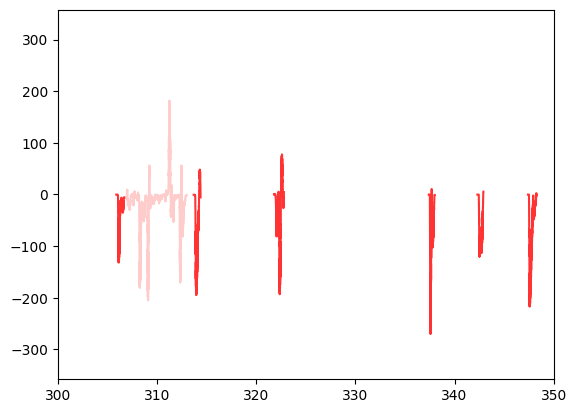

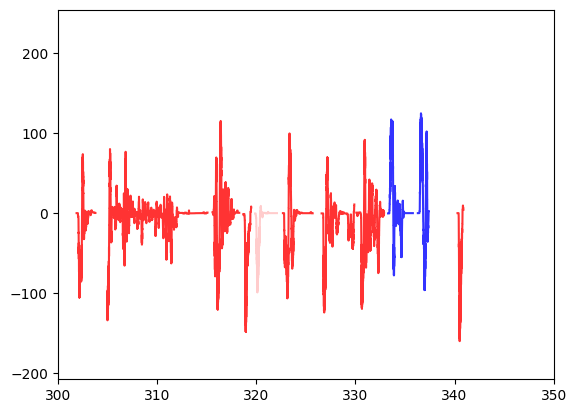

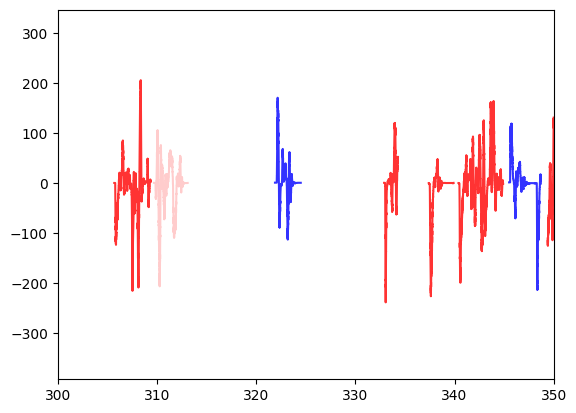

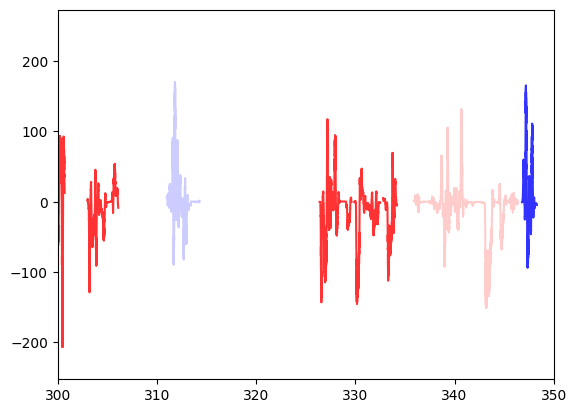

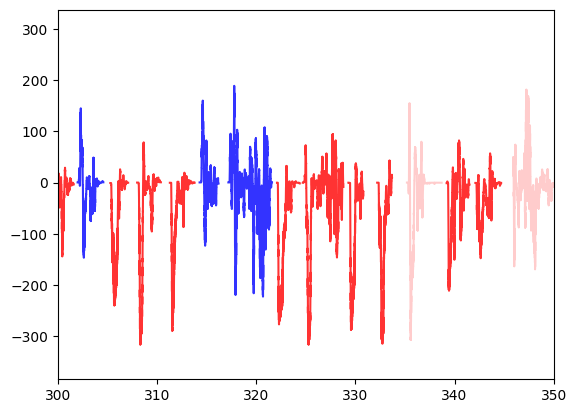

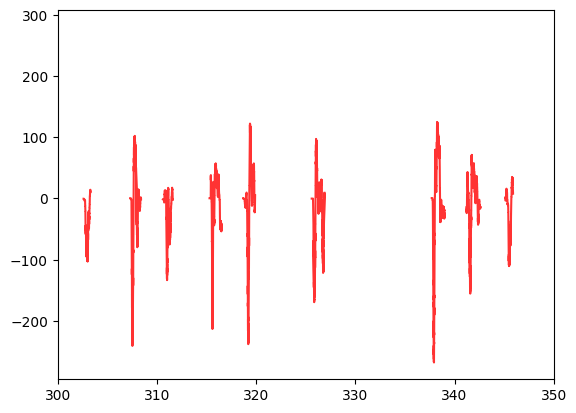

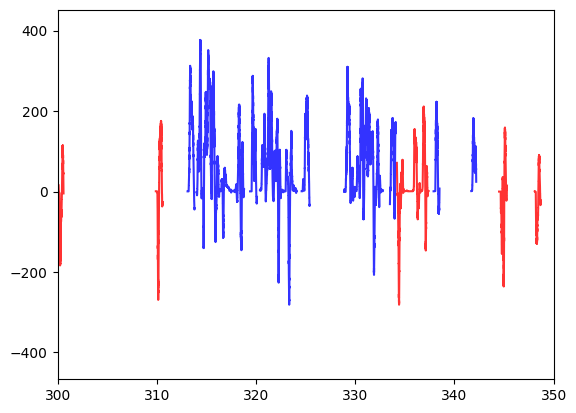

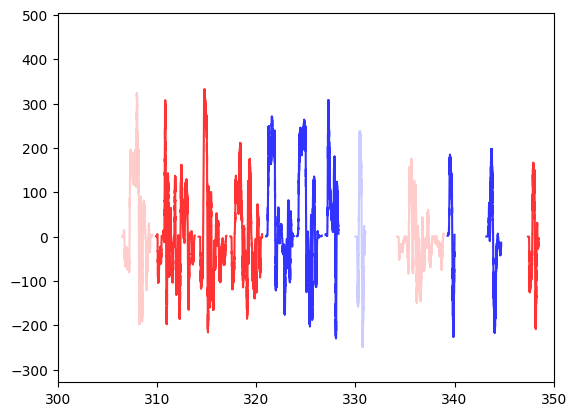

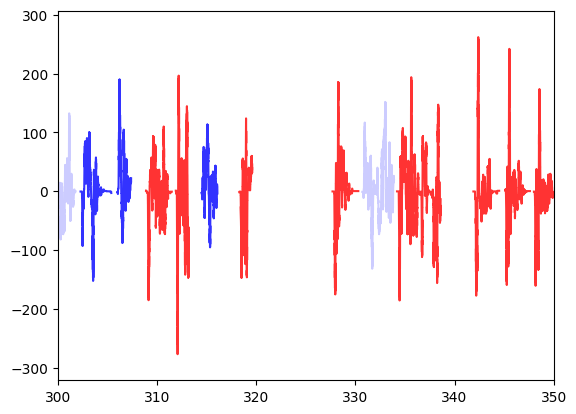

In [ ]:
sessions = mouse_movements_df['session'].unique()
for e, eid in enumerate(sessions):
    use_data = mouse_movements_df.loc[mouse_movements_df['session']==eid]

    # Plot
    balistic_left = use_data.loc[(use_data['ballistic']==True)
                                        & (use_data['response']==-1.)]
    balistic_right = use_data.loc[(use_data['ballistic']==True)
                                        & (use_data['response']==1.)]
    non_balistic_l = use_data.loc[(use_data['ballistic']==False)
                                        & (use_data['response']==-1.)]
    non_balistic_r = use_data.loc[(use_data['ballistic']==False)
                                        & (use_data['response']==1.)]
    no_response = use_data.loc[use_data['response']==np.nan]

    plt.plot(balistic_left['time'], balistic_left['wheel_vel'], color='red', alpha=0.8)
    plt.plot(balistic_right['time'], balistic_right['wheel_vel'], color='blue', alpha=0.8)
    plt.plot(non_balistic_l['time'], non_balistic_l['wheel_vel'], color='red', alpha=0.2)
    plt.plot(non_balistic_r['time'], non_balistic_r['wheel_vel'], color='blue', alpha=0.2)
    plt.plot(no_response['time'], no_response['wheel_vel'], color='grey', alpha=0.5)
    plt.xlim([300, 350])
    plt.show()

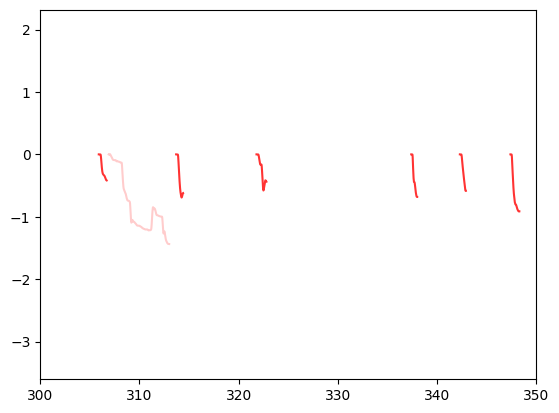

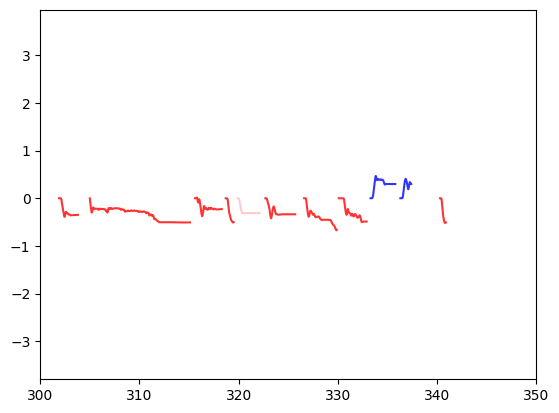

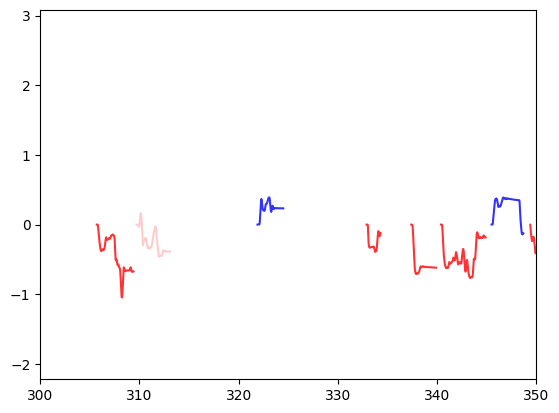

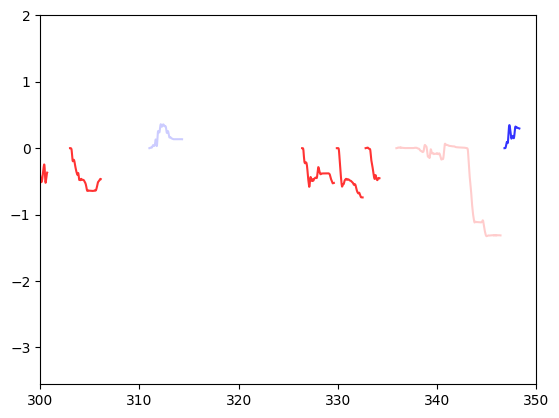

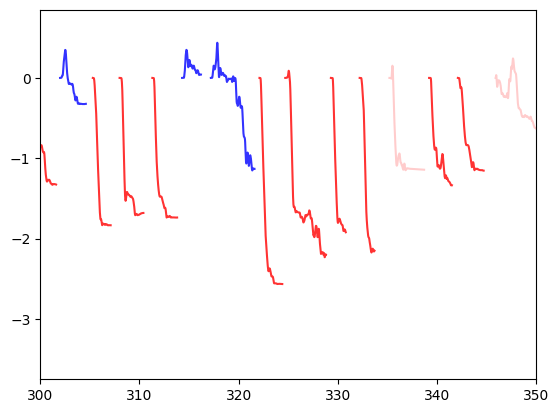

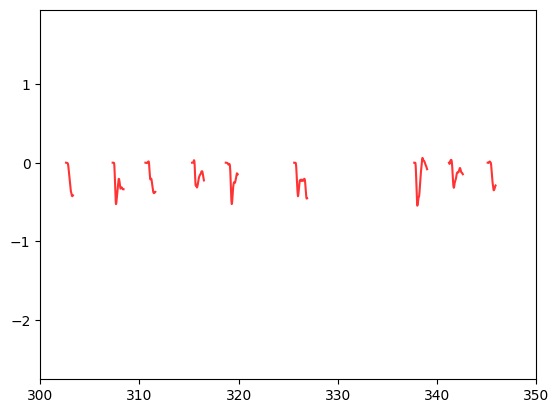

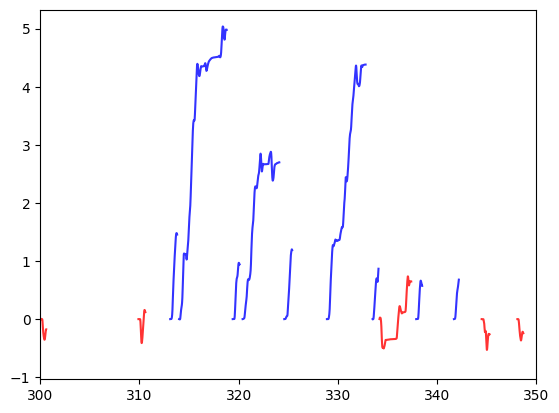

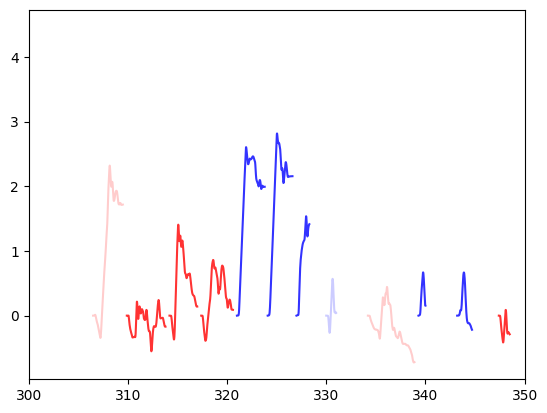

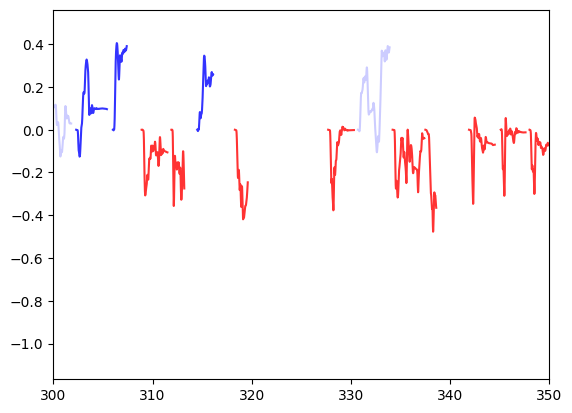

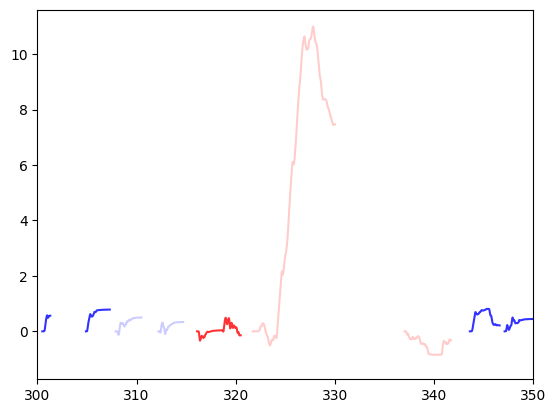

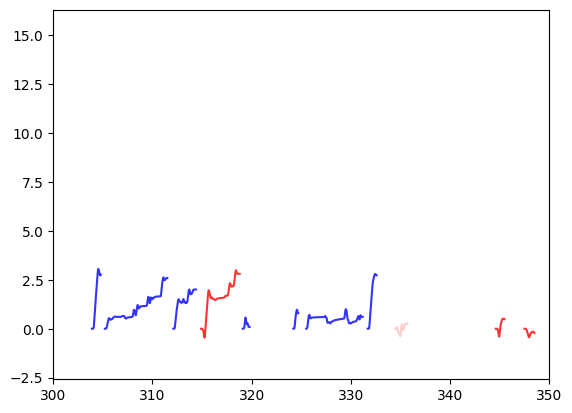

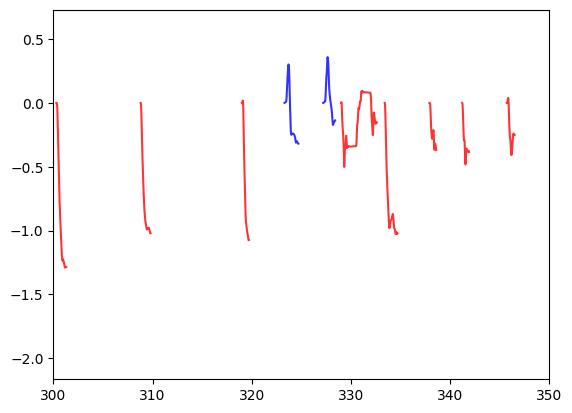

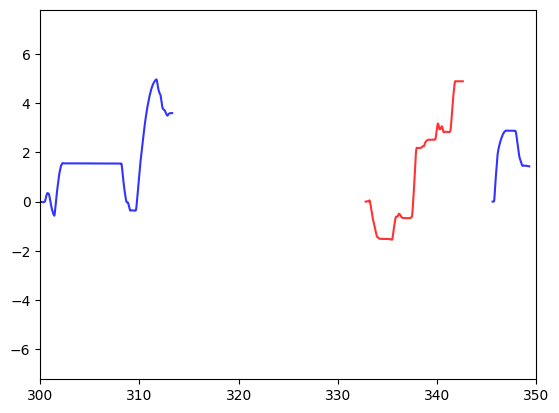

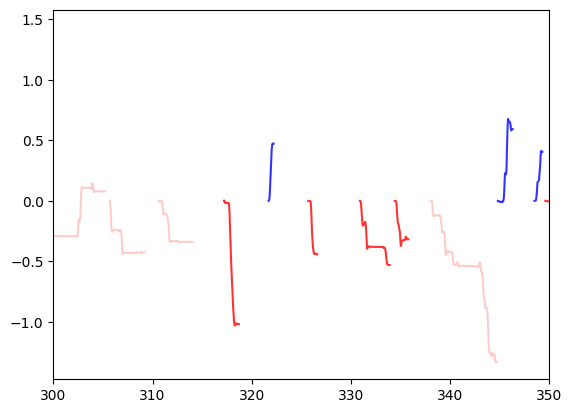

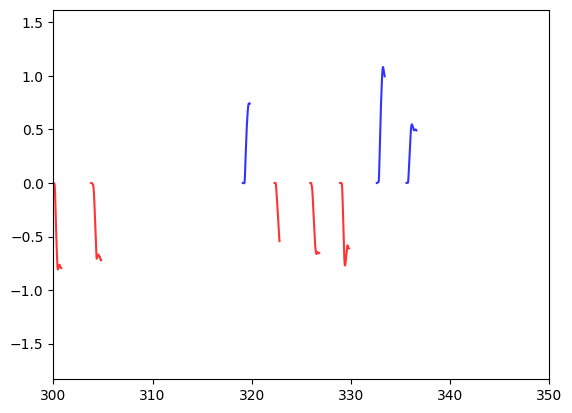

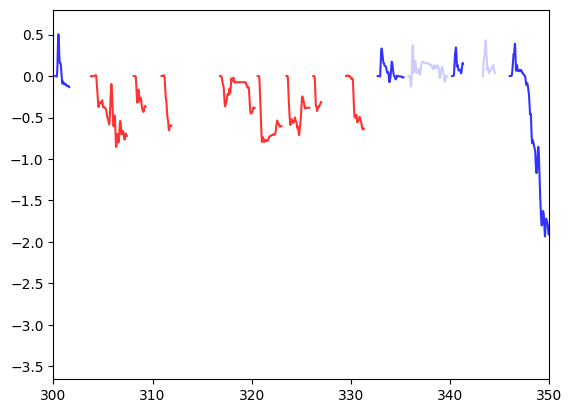

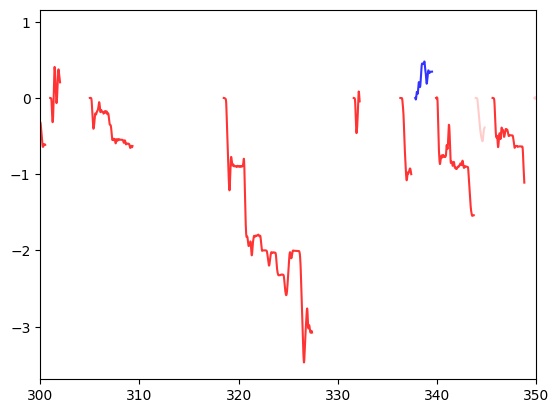

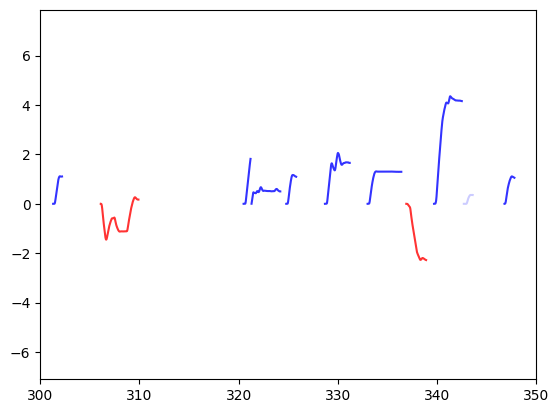

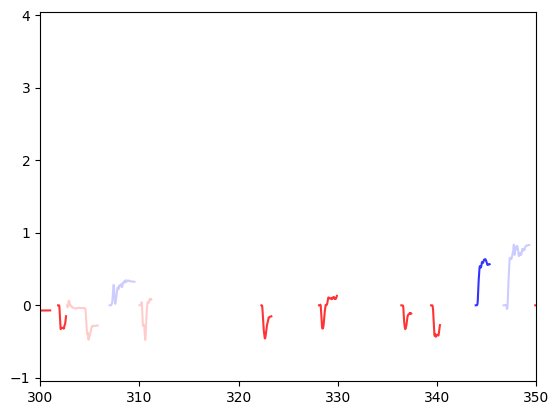

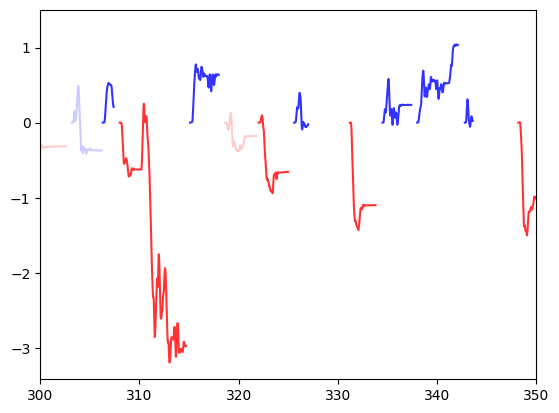

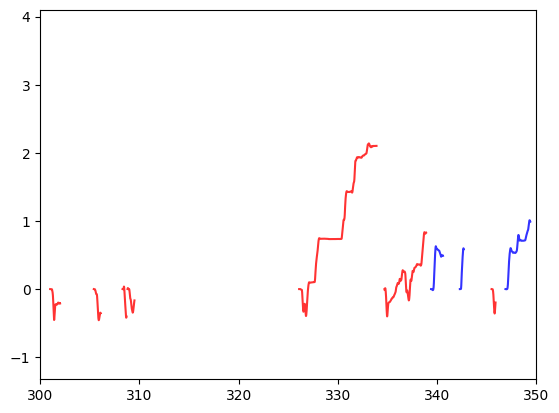

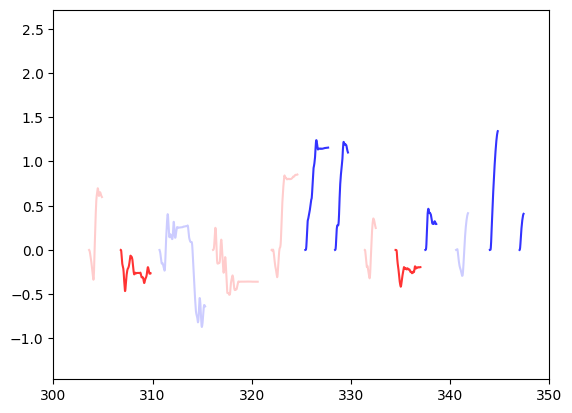

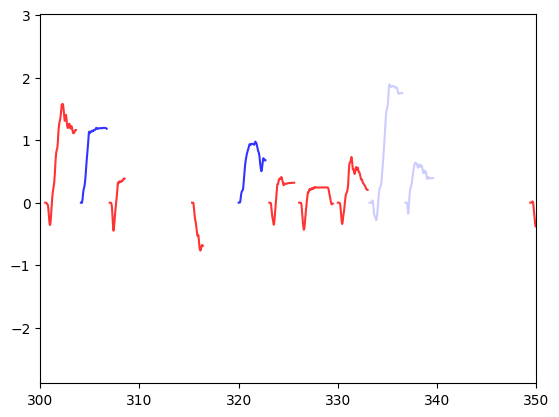

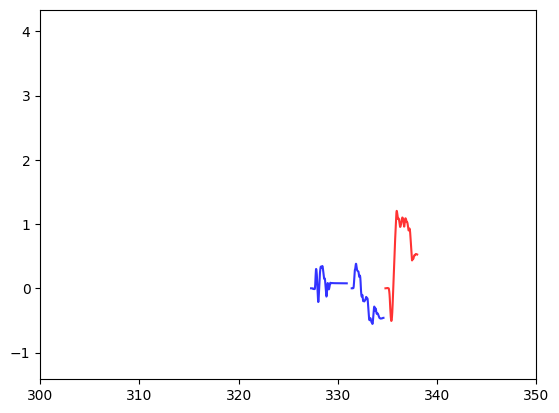

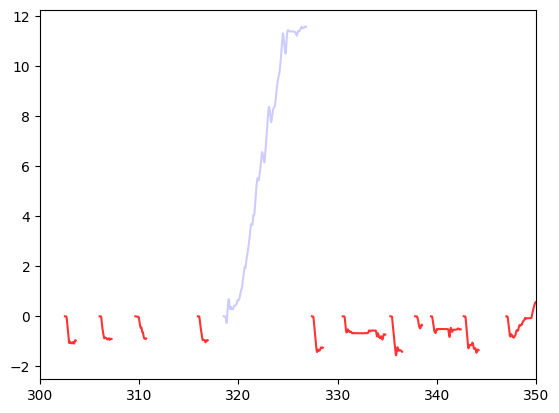

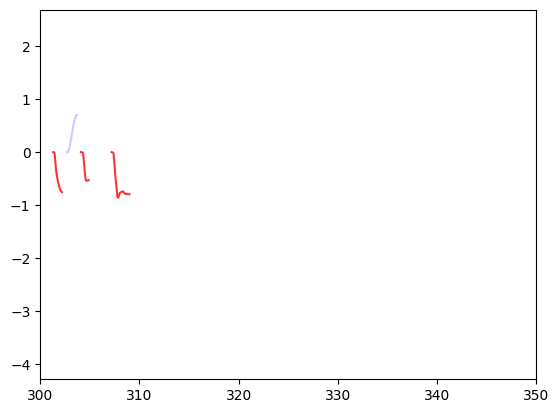

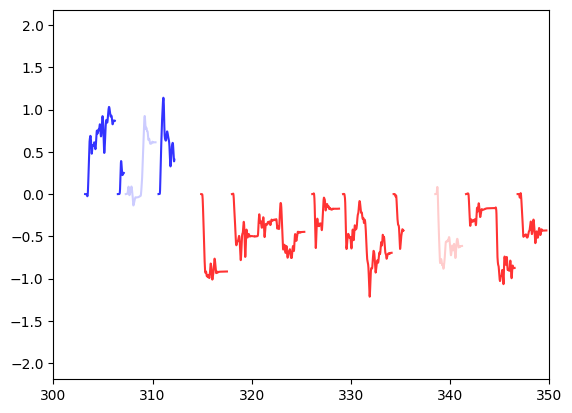

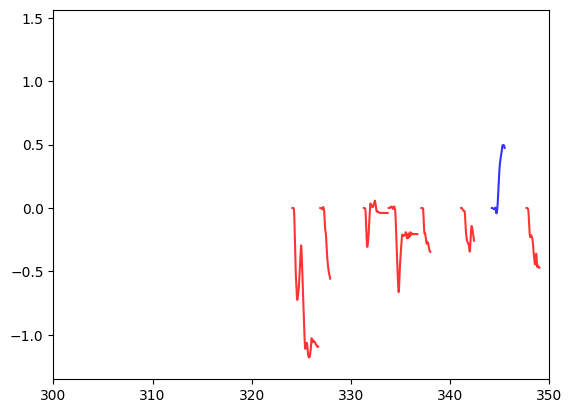

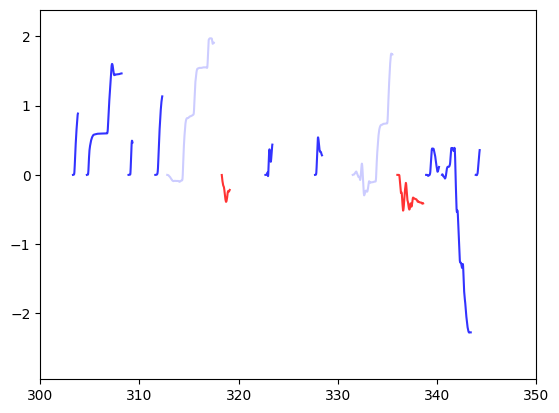

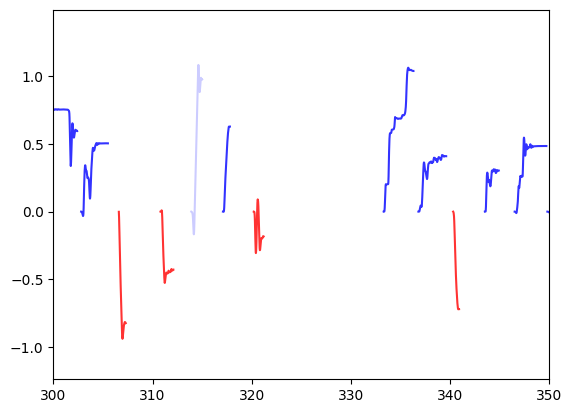

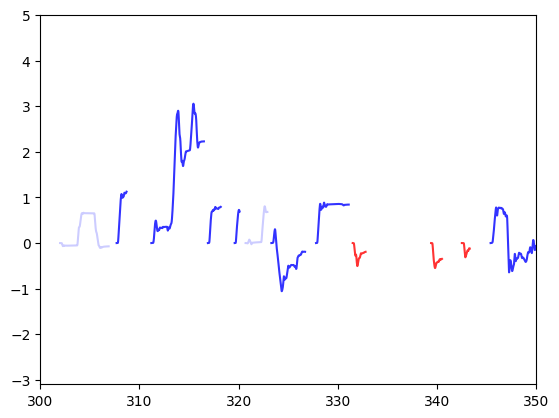

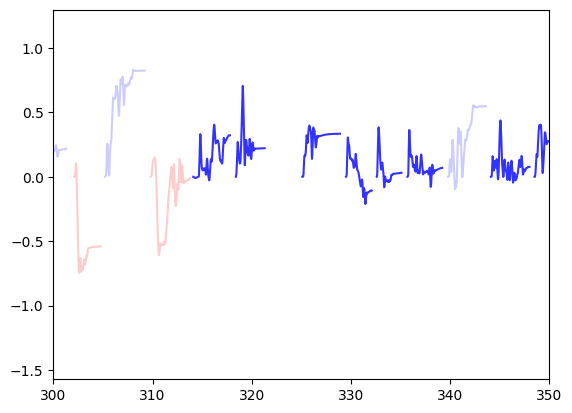

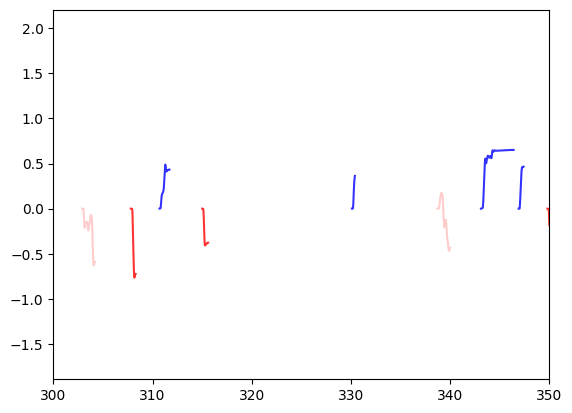

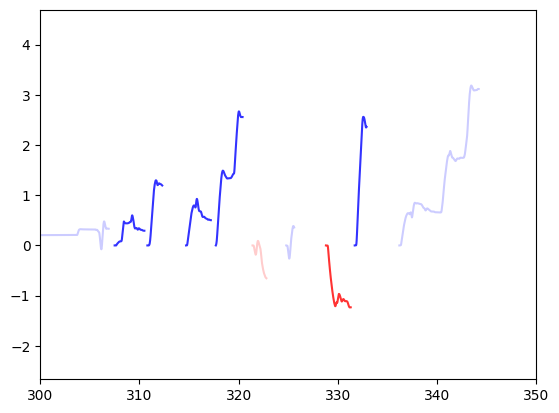

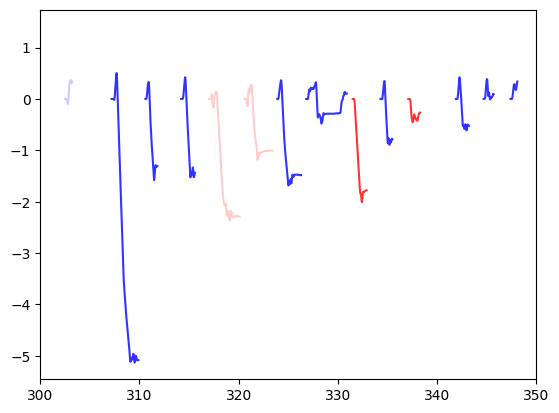

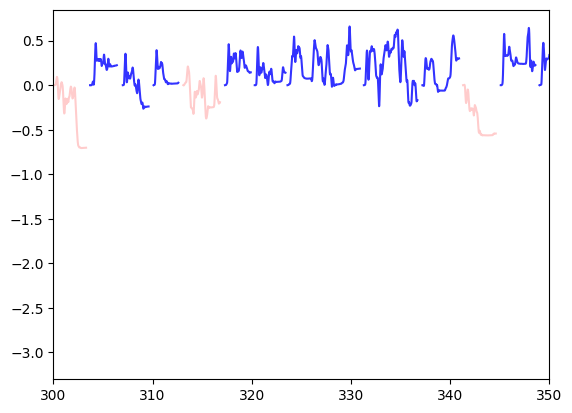

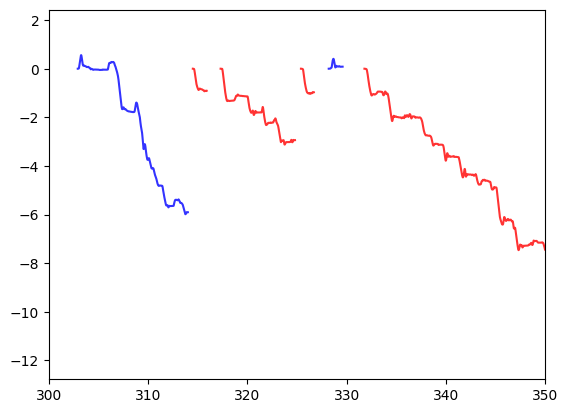

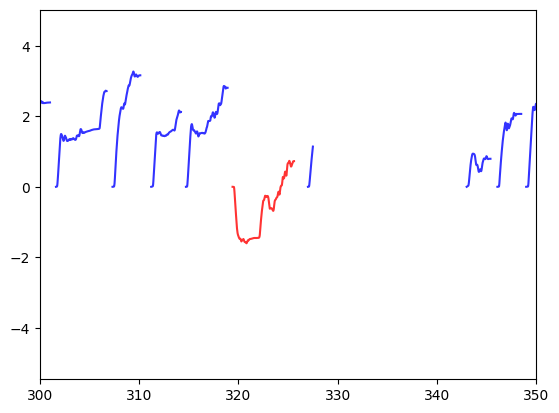

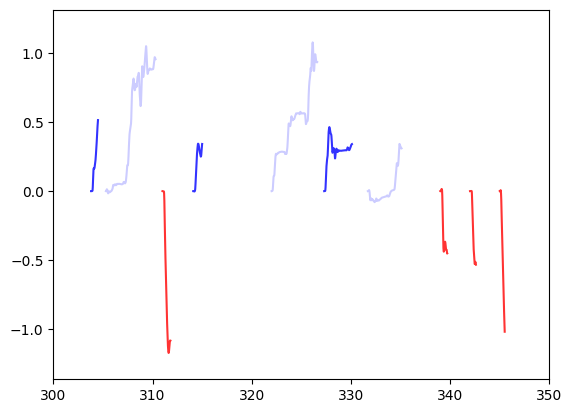

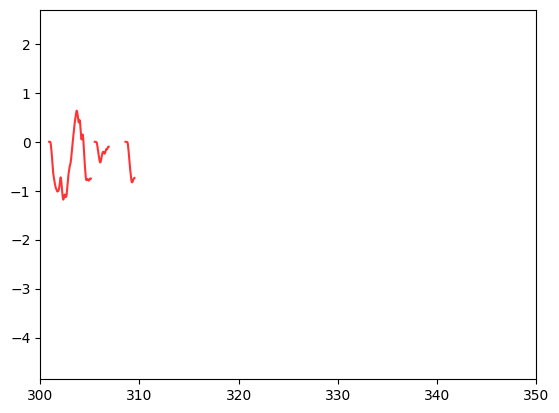

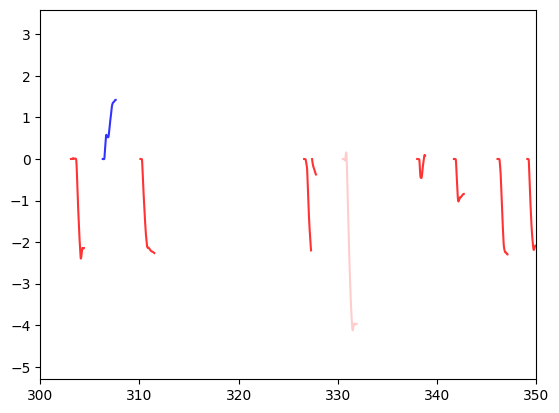

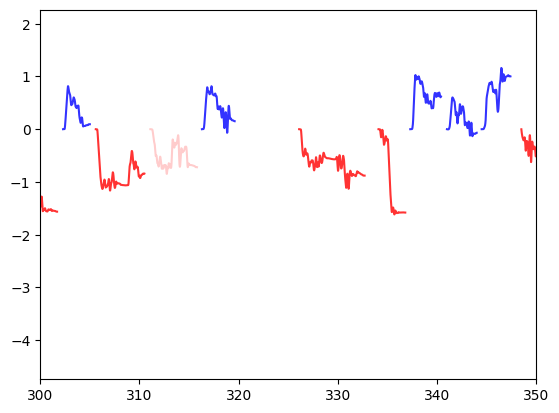

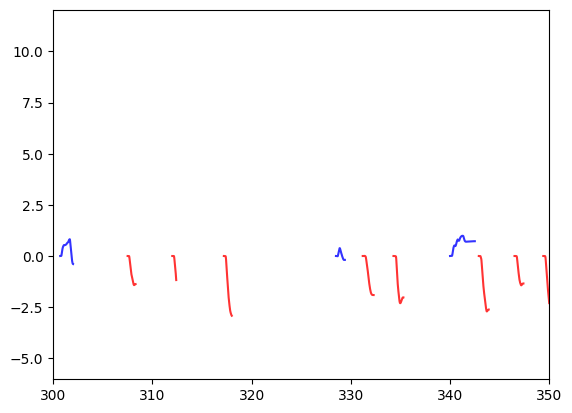

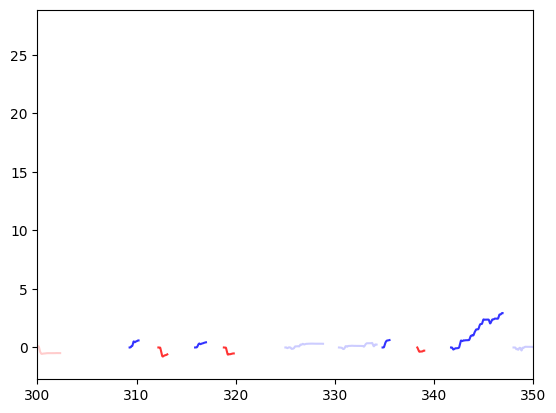

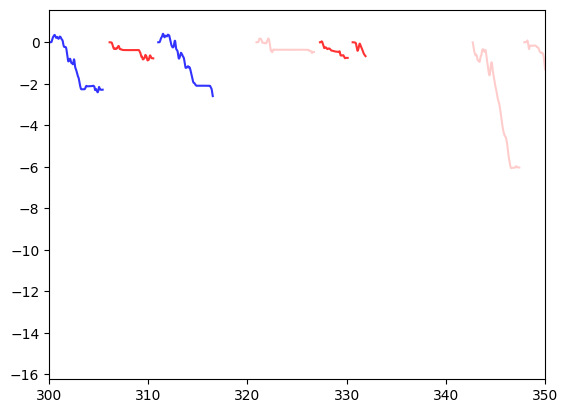

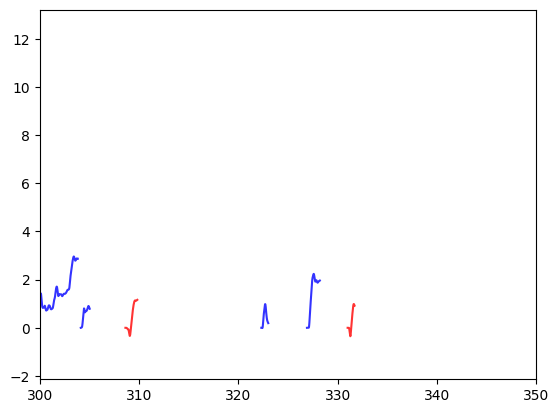

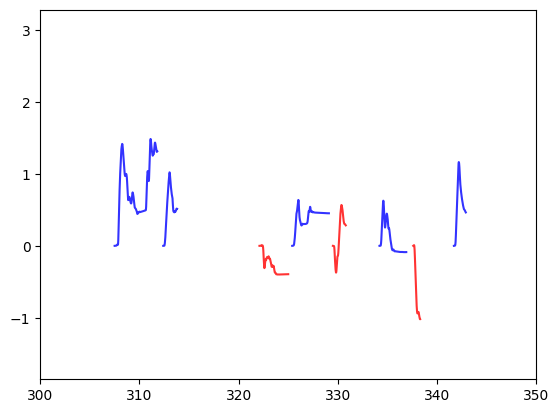

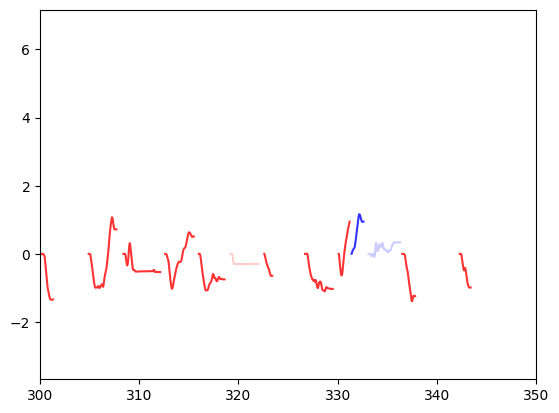

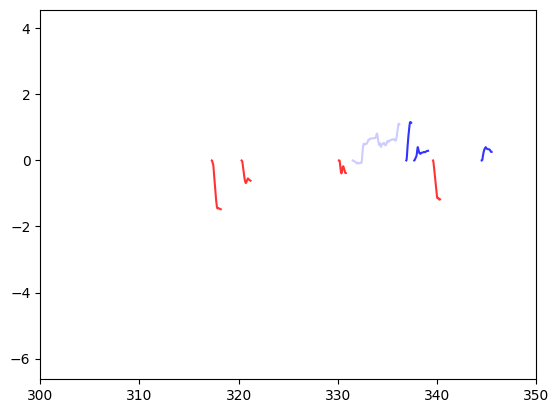

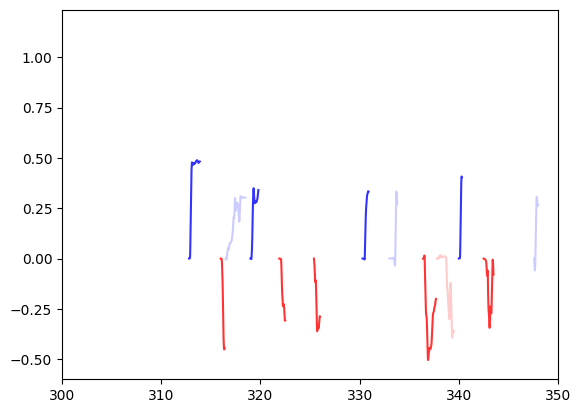

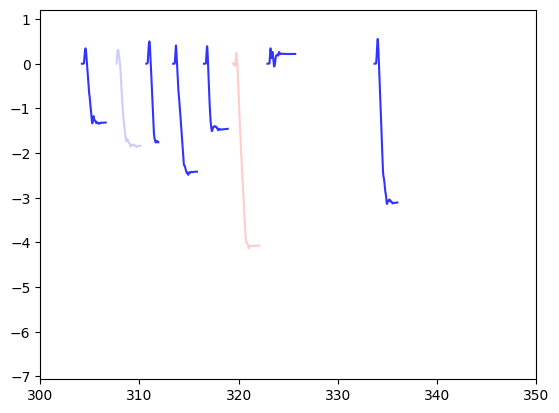

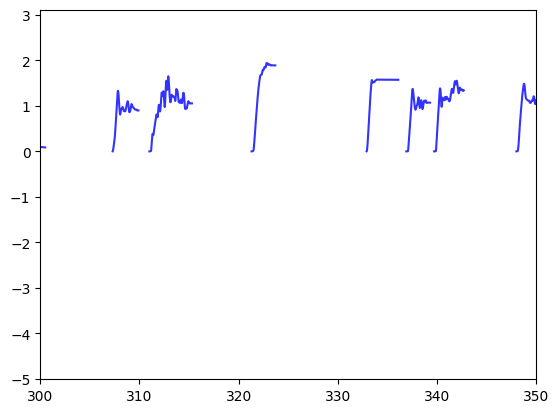

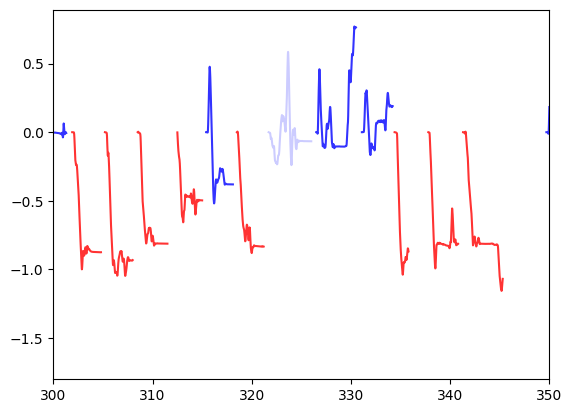

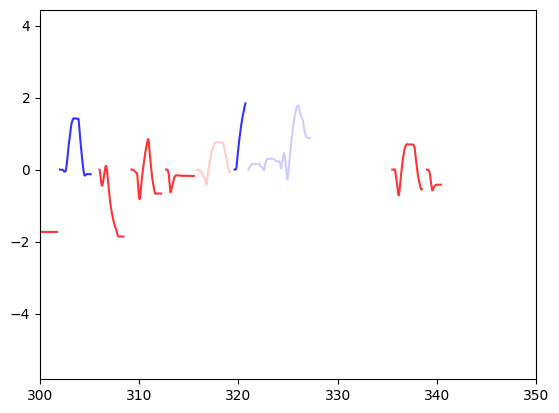

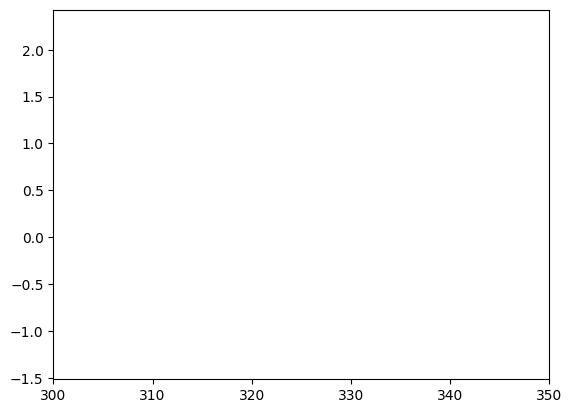

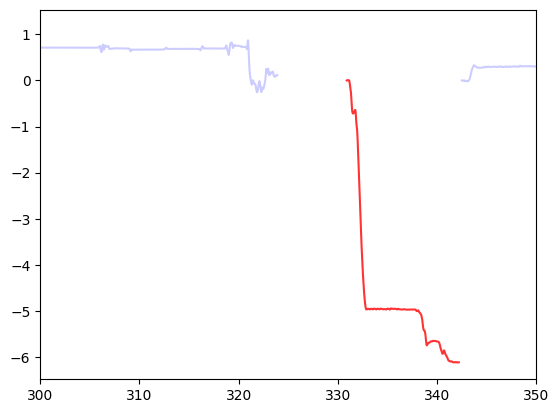

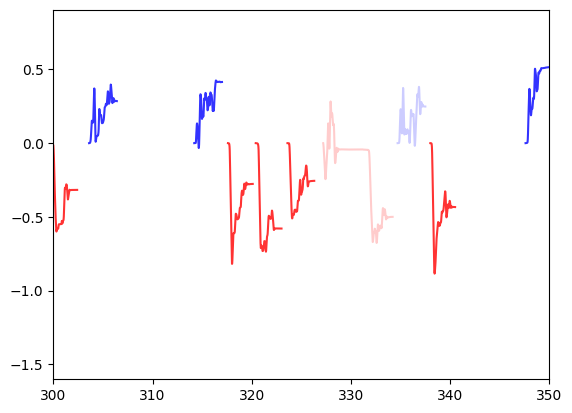

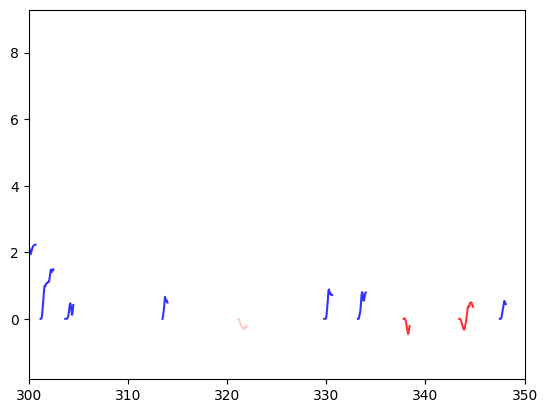

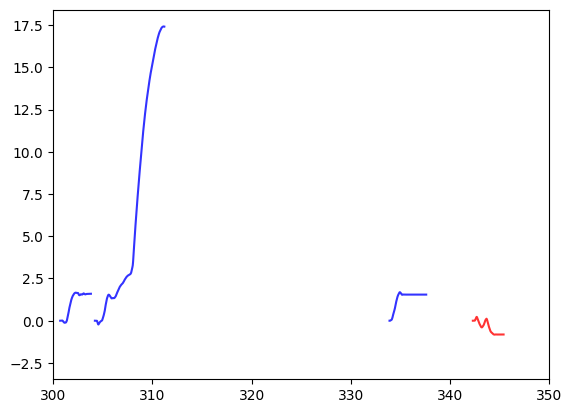

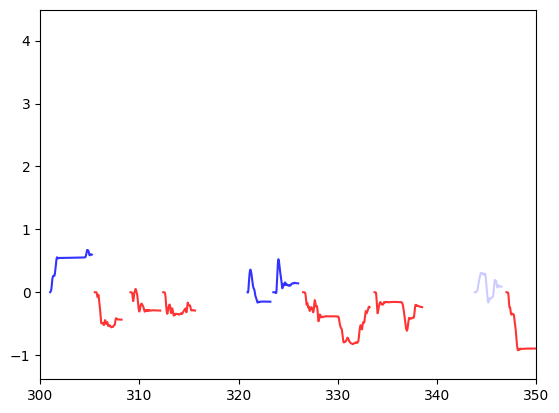

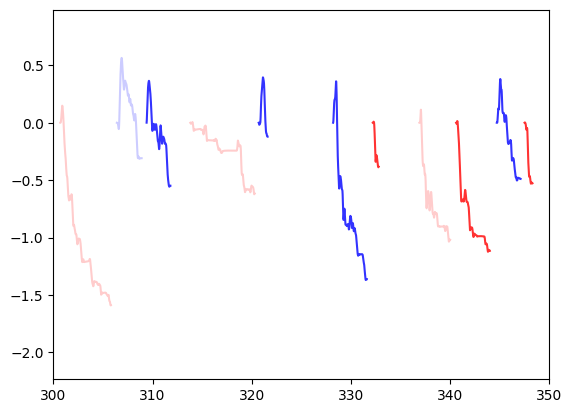

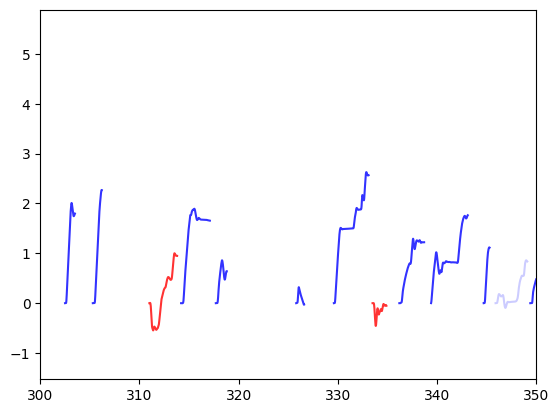

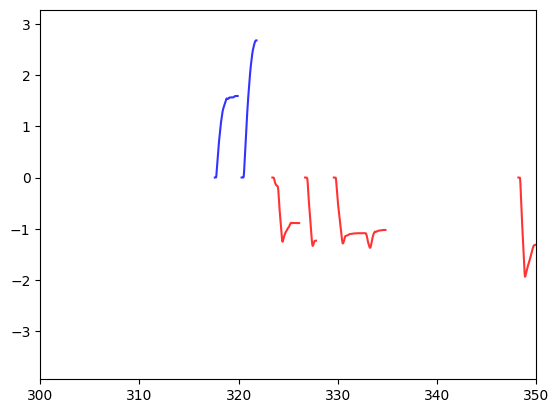

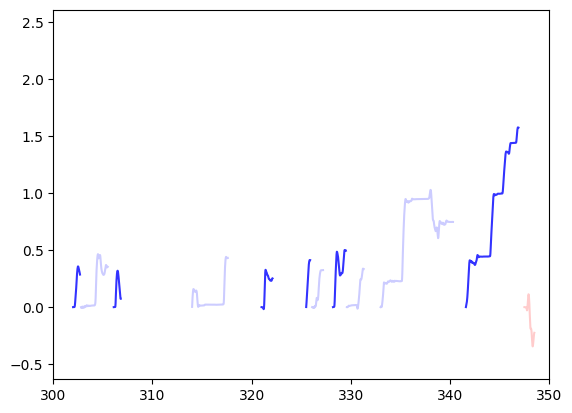

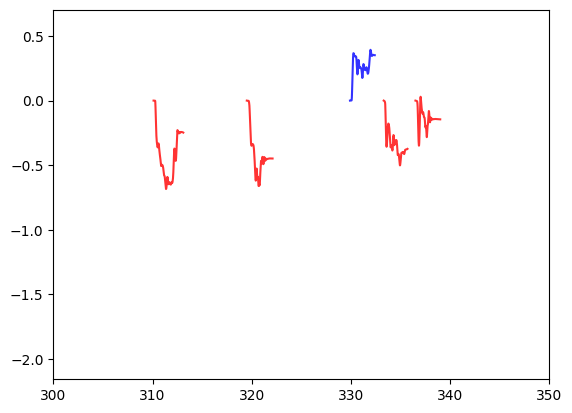

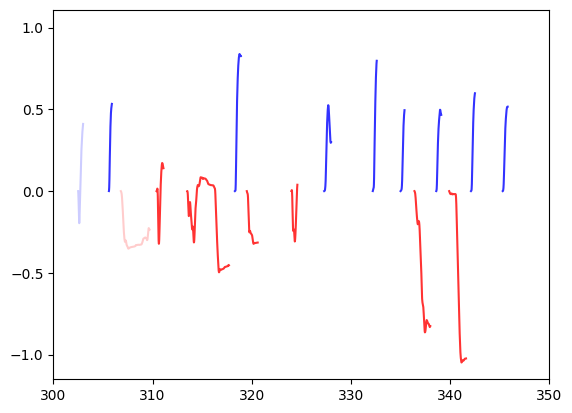

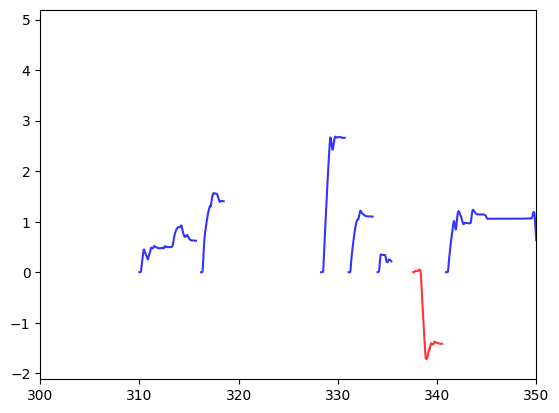

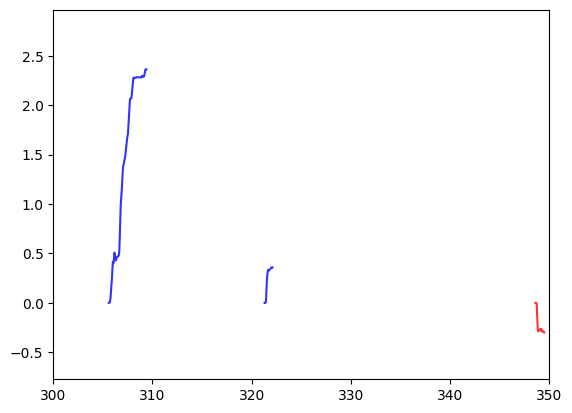

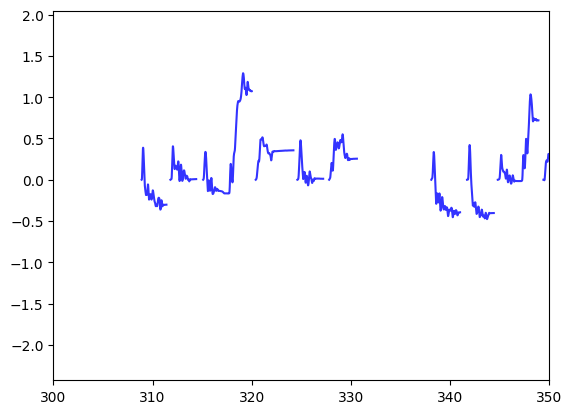

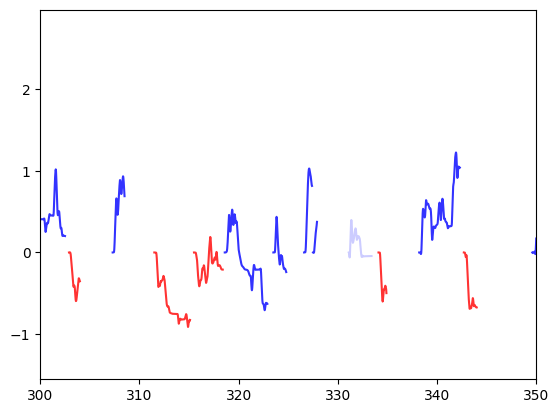

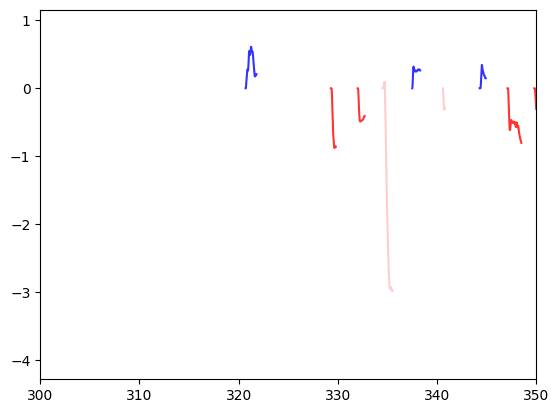

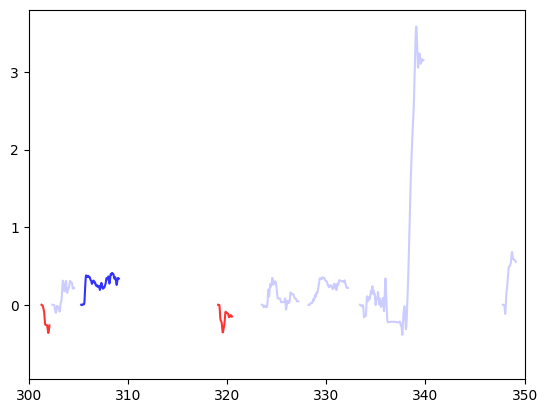

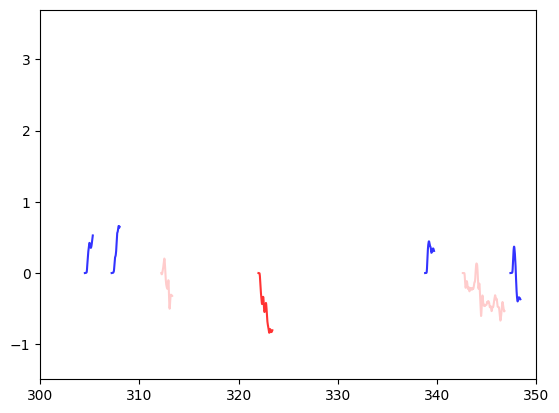

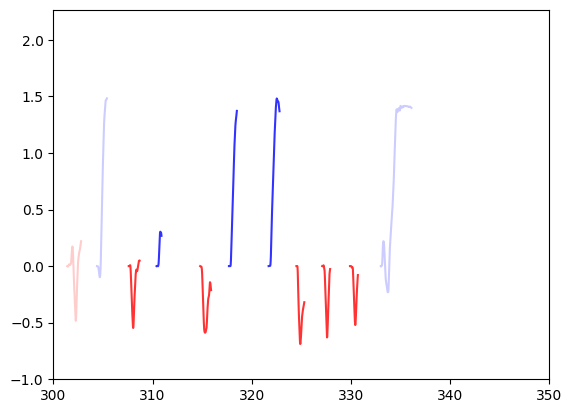

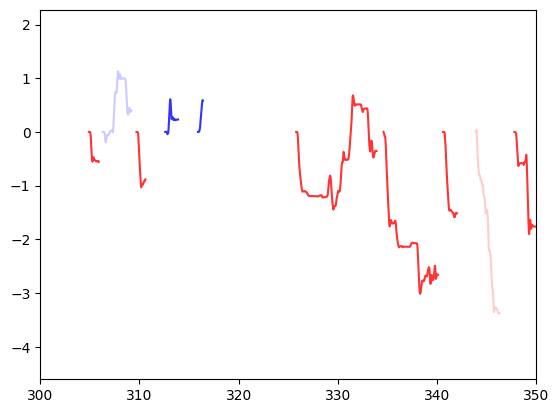

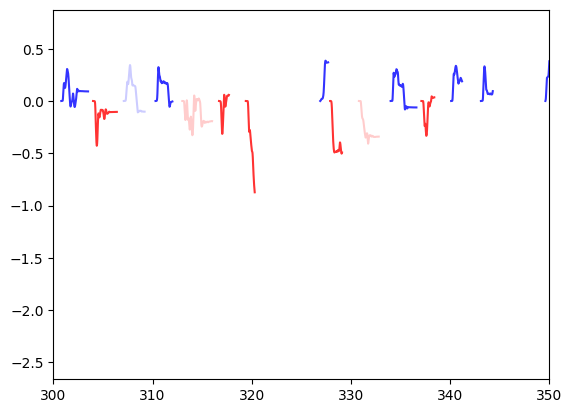

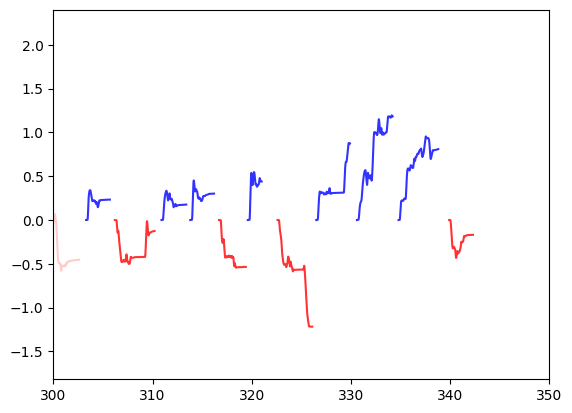

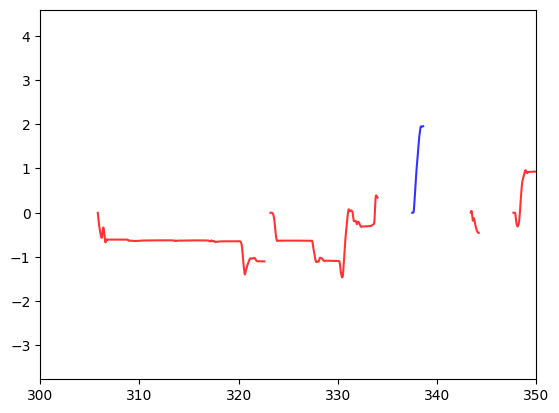

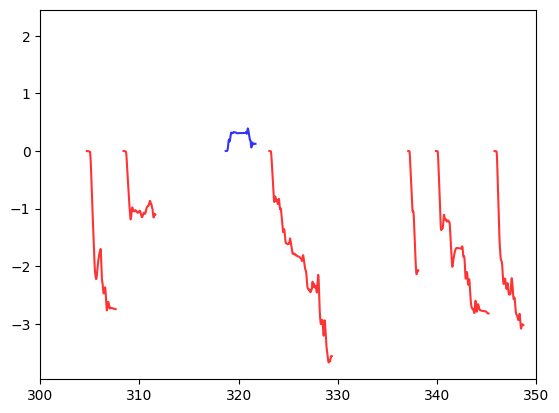

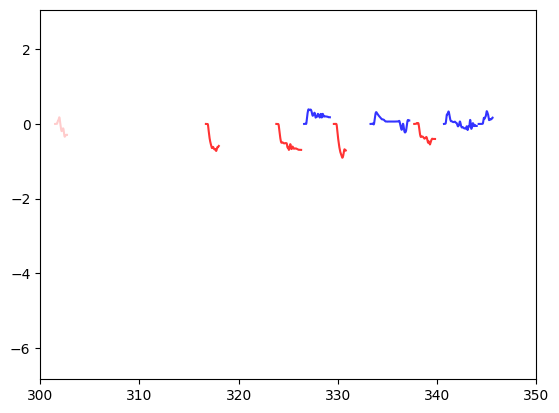

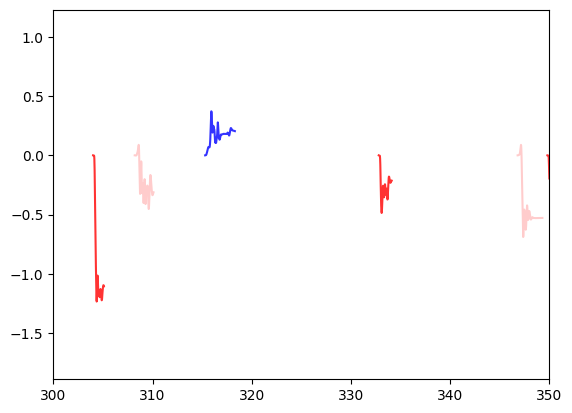

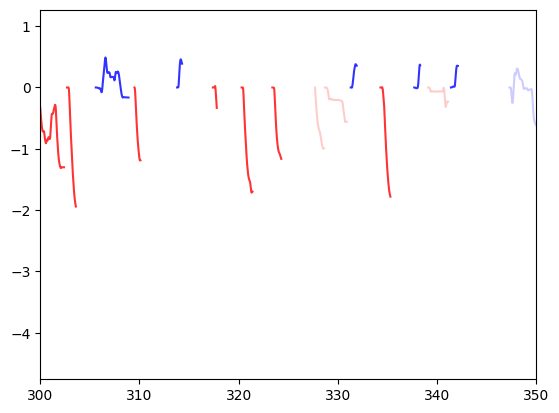

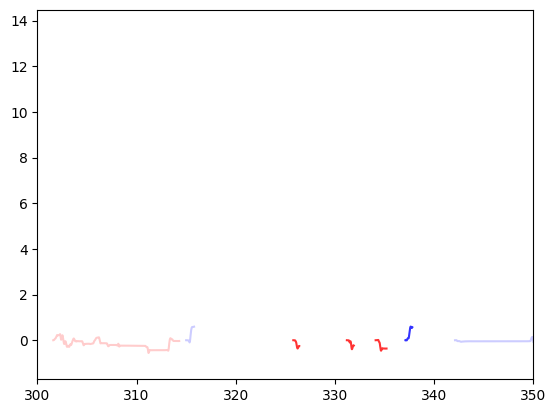

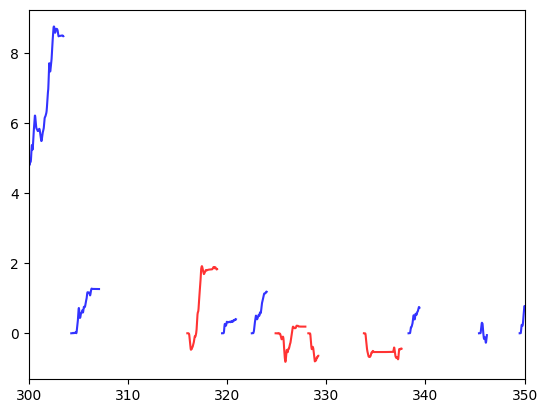

In [ ]:
sessions = mouse_movements_df['session'].unique()
for e, eid in enumerate(sessions):
    use_data = mouse_movements_df.loc[mouse_movements_df['session']==eid]
    # Plot
    balistic_left = use_data.loc[(use_data['ballistic']==True)
                                        & (use_data['response']==-1.)]
    balistic_right = use_data.loc[(use_data['ballistic']==True)
                                        & (use_data['response']==1.)]
    non_balistic_l = use_data.loc[(use_data['ballistic']==False)
                                        & (use_data['response']==-1.)]
    non_balistic_r = use_data.loc[(use_data['ballistic']==False)
                                        & (use_data['response']==1.)]
    no_response = use_data.loc[use_data['response']==np.nan]

    plt.plot(balistic_left['time'], balistic_left['wheel_pos'], color='red', alpha=0.8)
    plt.plot(balistic_right['time'], balistic_right['wheel_pos'], color='blue', alpha=0.8)
    plt.plot(non_balistic_l['time'], non_balistic_l['wheel_pos'], color='red', alpha=0.2)
    plt.plot(non_balistic_r['time'], non_balistic_r['wheel_pos'], color='blue', alpha=0.2)
    plt.plot(no_response['time'], no_response['wheel_pos'], color='grey', alpha=0.5)
    plt.xlim([300, 350])
    plt.show()

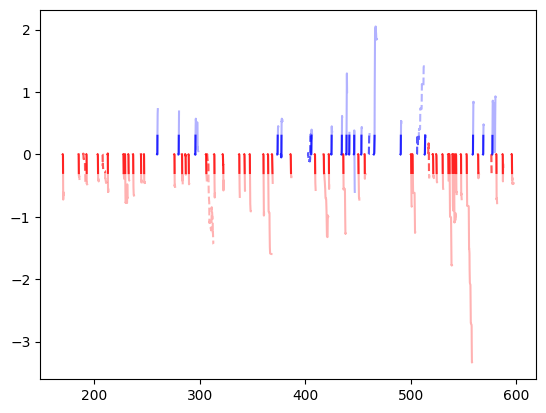

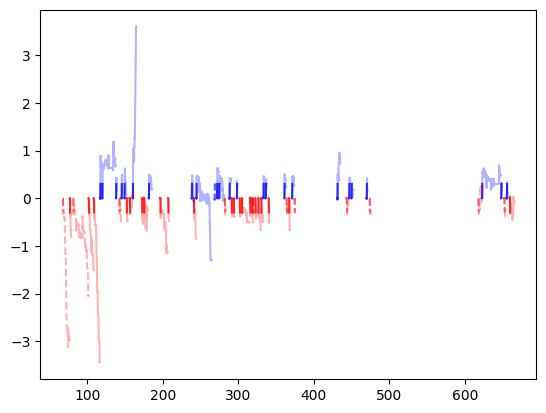

In [ ]:
sessions = mouse_movements_df['session'].unique()
for e, eid in enumerate(sessions):
    use_data = mouse_movements_df.loc[mouse_movements_df['session']==eid]
    # Plot
    balistic_left = use_data.loc[(use_data['ballistic']==True)
                                        & (use_data['response']==-1.)]
    balistic_right = use_data.loc[(use_data['ballistic']==True)
                                        & (use_data['response']==1.)]
    non_balistic_l = use_data.loc[(use_data['ballistic']==False)
                                        & (use_data['response']==-1.)]
    non_balistic_r = use_data.loc[(use_data['ballistic']==False)
                                        & (use_data['response']==1.)]
    no_response = use_data.loc[use_data['response']==np.nan]

    plt.plot(balistic_left['time'], balistic_left['wheel_pos_resp'], color='red', alpha=0.8)
    plt.plot(balistic_right['time'], balistic_right['wheel_pos_resp'], color='blue', alpha=0.8)
    plt.plot(non_balistic_l['time'], non_balistic_l['wheel_pos_resp'], color='red', alpha=0.5, linestyle='--')
    plt.plot(non_balistic_r['time'], non_balistic_r['wheel_pos_resp'], color='blue', alpha=0.5, linestyle='--')

    plt.plot(balistic_left['time'], balistic_left['wheel_pos'], color='red', alpha=0.3)
    plt.plot(balistic_right['time'], balistic_right['wheel_pos'], color='blue', alpha=0.3)
    plt.plot(non_balistic_l['time'], non_balistic_l['wheel_pos'], color='red', alpha=0.3, linestyle='--')
    plt.plot(non_balistic_r['time'], non_balistic_r['wheel_pos'], color='blue', alpha=0.3, linestyle='--')
    plt.plot(no_response['time'], no_response['wheel_pos'], color='grey', alpha=0.6)
    # plt.xlim([500, 550])
    plt.show()

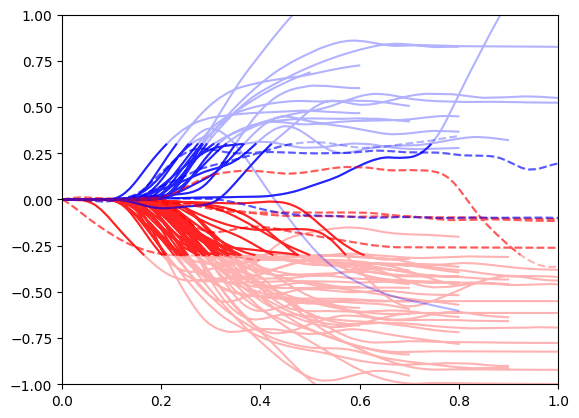

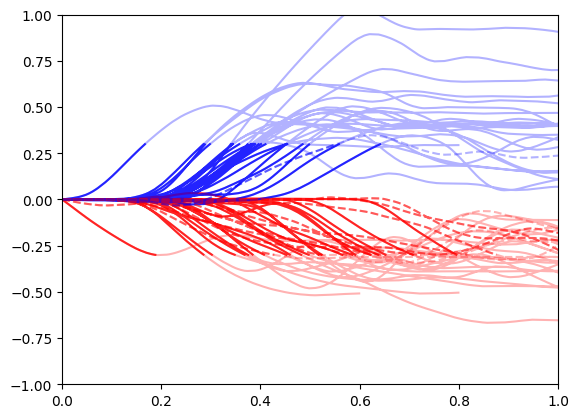

In [ ]:
sessions = mouse_movements_df['session'].unique()
for e, eid in enumerate(sessions):
    use_data = mouse_movements_df.loc[mouse_movements_df['session']==eid]
    # Plot
    balistic_left = use_data.loc[(use_data['ballistic']==True)
                                        & (use_data['response']==-1.)]
    balistic_right = use_data.loc[(use_data['ballistic']==True)
                                        & (use_data['response']==1.)]
    non_balistic_l = use_data.loc[(use_data['ballistic']==False)
                                        & (use_data['response']==-1.)]
    non_balistic_r = use_data.loc[(use_data['ballistic']==False)
                                        & (use_data['response']==1.)]
    no_response = use_data.loc[use_data['response']==np.nan]
    
    plt.plot(balistic_left['norm_time'], balistic_left['wheel_pos_resp'], color='red', alpha=0.8)
    plt.plot(balistic_right['norm_time'], balistic_right['wheel_pos_resp'], color='blue', alpha=0.8)
    plt.plot(non_balistic_l['norm_time'], non_balistic_l['wheel_pos_resp'], color='red', alpha=0.5, linestyle='--')
    plt.plot(non_balistic_r['norm_time'], non_balistic_r['wheel_pos_resp'], color='blue', alpha=0.5, linestyle='--')

    plt.plot(balistic_left['norm_time'], balistic_left['wheel_pos'], color='red', alpha=0.3)
    plt.plot(balistic_right['norm_time'], balistic_right['wheel_pos'], color='blue', alpha=0.3)
    plt.plot(non_balistic_l['norm_time'], non_balistic_l['wheel_pos'], color='red', alpha=0.3, linestyle='--')
    plt.plot(non_balistic_r['norm_time'], non_balistic_r['wheel_pos'], color='blue', alpha=0.3, linestyle='--')
    plt.plot(no_response['norm_time'], no_response['wheel_pos'], color='grey', alpha=0.6)
    plt.xlim([0,1])
    plt.ylim([-1, 1])
    plt.show()

(-4.0, 4.0)

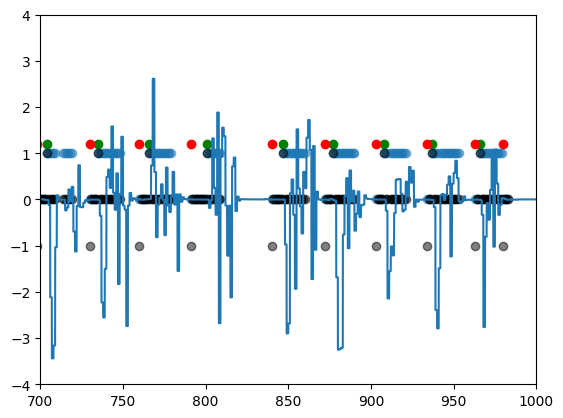

In [ ]:
plt.scatter(movement_onset, np.ones(len(movement_onset))+.2, color='green')
plt.scatter(movement_offset, np.ones(len(movement_offset))+.2, color='red')
# plt.plot(wheel_times*10, pos)
plt.plot(wheel_times*10, wheel_trace)
plt.scatter(df['Bin'], df['wheel_on'], alpha=0.5)
plt.scatter(df['Bin'], df['dif'], color='black', alpha=0.5)
plt.xlim([700, 1000])
plt.ylim([-4, 4])